<center>
<img src="https://github.com/Yorko/mlcourse.ai/blob/master/img/ods_stickers.jpg?raw=1">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 4. Где логистическая регрессия хороша и где не очень

### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет  – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

![img](https://github.com/Yorko/mlcourse.ai/blob/master/img/bag_of_words.svg?raw=1)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (это прямая ссылка на скачивание, а [вот](http://ai.stanford.edu/~amaas/data/sentiment/) описание набора данных). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [2]:
!wget 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
!tar -xf aclImdb_v1.tar.gz
!ls -l aclImdb

--2019-10-13 10:51:34--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.2MB/s    in 4.4s    

2019-10-13 10:51:39 (18.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

total 1724
-rw-r--r-- 1 7297 1000 903029 Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 845980 Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000   4037 Jun 26  2011 README
drwxr-xr-x 4 7297 1000   4096 Oct 13 10:51 test
drwxr-xr-x 5 7297 1000   4096 Oct 13 10:51 train


In [0]:
reviews_train = load_files("aclImdb/train")
text_train = [reviews_train.data[i] for i in range(len(reviews_train.data)) if reviews_train.target[i] < 2]
y_train = [reviews_train.target[i] for i in range(len(reviews_train.data)) if reviews_train.target[i] < 2]

In [4]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [5]:
reviews_test = load_files("aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [6]:
text_train[2]

b"Outlandish premise that rates low on plausibility and unfortunately also struggles feebly to raise laughs or interest. Only Hawn's well-known charm allows it to skate by on very thin ice. Goldie's gotta be a contender for an actress who's done so much in her career with very little quality material at her disposal...<br /><br />"

In [7]:
y_train[2] # плохой отзыв

0

In [8]:
text_train[1]

b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum while still keeping us creeped out.'

In [9]:
y_train[1] # хороший отзыв

1

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [10]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [11]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [12]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [13]:
text_train[19726]

b"The One and only was a great film. I had just finished viewing it on EncoreW on DirecTV. I am an independent professional wrestler, and I thought this was a good portray of what life is like as a professional wrestler. Now this film was made 4 years before I was born, but I don't think the rigors of professional wrestling traveling has changed all that much. Sad, funny, and all around GREAT!!! **** 10+"

In [14]:
X_train[19726].nonzero()[1]

array([   39,  2662,  2906,  3167,  3258,  4297,  4465,  6579,  8523,
        9881, 11552, 18584, 19563, 21741, 24536, 24666, 26385, 28068,
       28545, 29369, 29999, 33283, 34585, 34683, 35787, 38683, 38755,
       40170, 44241, 46152, 46680, 46916, 46932, 46957, 50946, 51875,
       55851, 57047, 66322, 66339, 66526, 66562, 66621, 67948, 71337,
       72196, 72703, 73795, 73798, 74158], dtype=int32)

In [15]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 array([   39,  2662,  2906,  3167,  3258,  4297,  4465,  6579,  8523,
         9881, 11552, 18584, 19563, 21741, 24536, 24666, 26385, 28068,
        28545, 29369, 29999, 33283, 34585, 34683, 35787, 38683, 38755,
        40170, 44241, 46152, 46680, 46916, 46932, 46957, 50946, 51875,
        55851, 57047, 66322, 66339, 66526, 66562, 66621, 67948, 71337,
        72196, 72703, 73795, 73798, 74158], dtype=int32))

**Преобразуем так же тестовую выборку.**

In [0]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию.**

In [17]:
X_train.shape, X_test.shape

((25000, 74849), (25000, 74849))

In [18]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 25.3 s, sys: 17.4 s, total: 42.7 s
Wall time: 21.6 s


**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [19]:
logit.score(X_train, y_train), logit.score(X_test, y_test)

(0.99832, 0.86672)

**Коэффициенты модели можно красиво отобразить.**

In [0]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.array(feature_names)[interesting_coefficients], coef[interesting_coefficients], color=colors)
    plt.xticks(rotation=60, ha="right")
    plt.show()

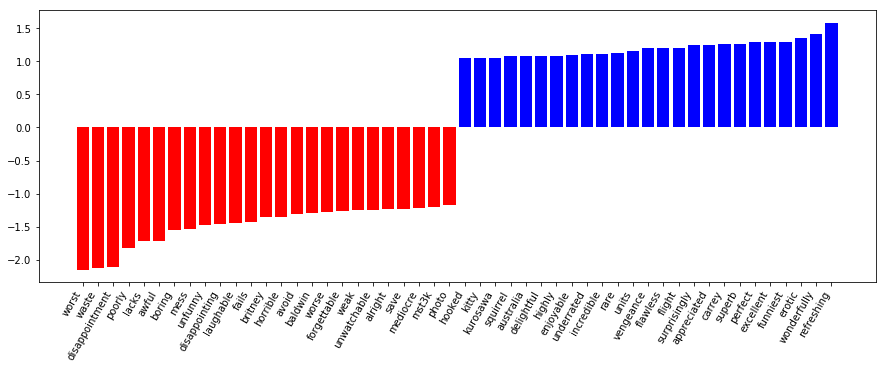

In [50]:
visualize_coefficients(logit, cv.get_feature_names())

**Подберем коэффициент регуляризации для логистической регрессии. Используем `sklearn.pipeline`, поскольку `CountVectorizer` правильно применяется только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае `pipeline` задает последовательность действий: применить `CountVectorizer`, затем обучить логистическую регрессию.**

In [60]:
%%time
from sklearn.pipeline import make_pipeline
text_pipe_logit = make_pipeline(CountVectorizer(), LogisticRegression(n_jobs=-1, random_state=7))
text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.86672
CPU times: user 33.6 s, sys: 17.7 s, total: 51.2 s
Wall time: 29.8 s


In [56]:
train_names = set(CountVectorizer().fit(text_train, y_train).get_feature_names())
test_names = set(CountVectorizer().fit(text_test, y_test).get_feature_names())
len(train_names), len(test_names)

(74849, 73822)

In [57]:
test_unique_names = set([x for x in test_names if x not in train_names])
len(test_unique_names)

27046

In [67]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, verbose=3, return_train_score=True)
grid_logit.fit(text_train, y_train)
print('Лучшее значение C и соответствующее качество на кросс-валидации:', grid_logit.best_params_, grid_logit.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Лучшее значение C и соответствующее качество на кросс-валидации: {'logisticregression__C': 0.1} 0.88488
CPU times: user 32.3 s, sys: 8.29 s, total: 40.6 s
Wall time: 2min 52s


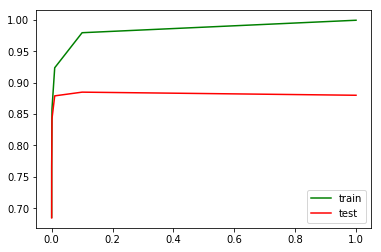

In [68]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend()
    plt.show()
plot_grid_scores(grid_logit, 'logisticregression__C')

На валидационной выборке:

In [69]:
grid_logit.score(text_test, y_test)

0.87908

**Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями**

In [72]:
%%time
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))

0.85368
CPU times: user 3min 49s, sys: 204 ms, total: 3min 49s
Wall time: 1min 56s


### XOR-проблема
Теперь рассмотрим пример, где линейные модели справляются хуже. 

Линейные методы классификации строят все же очень простую разделяющую поверхность – гиперплоскость. Самый известный игрушечный пример, в котором классы нельзя без ошибок поделить гиперплоскостью (то есть прямой, если это 2D), получил имя "the XOR problem".

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src='https://github.com/Yorko/mlcourse.ai/blob/master/img/XOR_table.gif?raw=1'>

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек. 

In [0]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

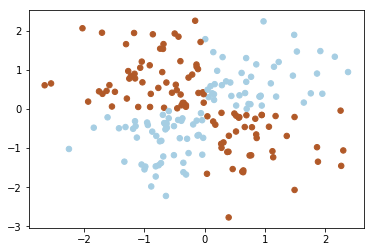

In [74]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)

Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей. 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


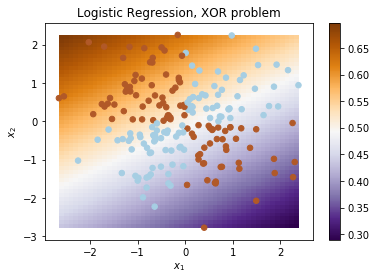

In [100]:
def plot_boundary(clf, X, y, plot_title):
    y = y.astype(int)
    clf.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 50), np.linspace(X[:,1].min(), X[:,1].max(), 50))
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:,1]
    Z = Z.reshape(xx.shape)
    #print(clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T))
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    plt.scatter(X[:,0],X[:,1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12)
    plt.show()
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается. 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


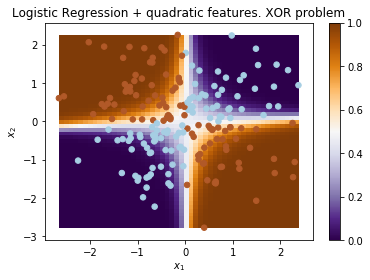

In [103]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все равно строила гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. В проекции на исходное пространство признаков $x_1, x_2$ граница получилась нелинейной. 

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится. Про это подробно можно почитать в курсе Евгения Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem10_linear.pdf) (математика уже серьезная).